In [1]:
import pandas as pd
import numpy as np
from matrixprofile import *
from matrixprofile.discords import discords
from matplotlib import pyplot as plt
from scipy.io import arff
from binarytree import Node
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import entropy
from math import log, e
import pydotplus
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [2]:
def retrieve_all(Ts,window_size): #fornita la Ts calcola e restituisce mp, motifs, motifs_distances e discords
    Ts=Ts[0:127] #rimuovo l'attributo "classe"

    dfMP = pd.DataFrame(Ts).astype(float) # genero Dframe per lavorarci su, DA CAPIRE PERCHE SERVE FLOAT
    mp, mpi = matrixProfile.stomp(dfMP[0].values,window_size) #OK STOMP

    #PREPARO TUPLA DA PASSARE ALLA FUN MOTIF (RICHIEDE TUPLA FATTA DA MP E MPI)
    tupla=mp,mpi

    mot, motif_dist  =motifs.motifs(dfMP[0].values,tupla,2)

    #CALCOLO MOTIFS
   # print('Motifs starting position: '+str(mot)+ ' Motifs values (min distances): '+str(motif_dist))
   # print(" ")

    #CALCOLO DISCORDS
    dis= discords(mp,window_size,2)
    #print('Discords starting position: '+str(dis))
    
    tupla=mp,mot,motif_dist,dis
    return tupla

In [3]:
#ogni motif e identificato da almeno due indici di partenza nella Ts, ne prendo uno solo rappresentativo
#genero poi struttura contenente gli indici di partenza di tutti i candidati

def candidateFilter(CandidatesList): 
    counterNumberMotif=0
    counterNumberDiscord=0
    l2=np.array([])
    for i in range (len(CandidatesList['Motif'])): #per ogni entry (per ogni record)
        numMotif=len(CandidatesList['Motif'].iloc[i])
        numDiscord=len(CandidatesList['Discord'].iloc[i])
        counterNumberDiscord+=numDiscord
        #print(numMotif)
        for j in range (numMotif): # per ogni lista di motif
            l1=CandidatesList['Motif'].iloc[i] #prima lista
            l2=np.append(l2,l1[j][0]) #prendo primo valore di ogni lista
            counterNumberMotif+=1
            
    
        CandidatesList['Motif'].iloc[i]=l2
        l2=np.array([]) #svuoto array
    
    return CandidatesList,counterNumberMotif,counterNumberDiscord

In [4]:
def getDataStructures(df,window_size):
    #trasformo da stringa a numero il campo target 
    le = LabelEncoder()
    num_classes = le.fit_transform(df['target'])
    df['target']=num_classes
    df['TsIndex']=np.arange(len(df))
    window_size=5
    #diz={'Motif':[],'Motif-Dist':[],'Discord':[]}
    diz={'Motif':[],'Discord':[]}

    #CALCOLO MOTIF E DISCORD E LI INSERISCO NEL DIZIONARIO
    for i in range(len(df)):
        Ts = np.array(df.iloc[i][0:-2].values)
        mp,mot,motif_dist,dis = retrieve_all(Ts,window_size)
        diz['Motif'].insert(i, mot)
        diz['Discord'].insert(i, dis)

    #GENERO DFRAME DA DIZIONARIO

    CandidatesList = pd.DataFrame(diz)
    CandidatesList,numberOfMotif,numberOfDiscord=candidateFilter(CandidatesList)
    #CandidatesUsedList=buildCandidatesUsedList(CandidatesList,numberOfMotif,numberOfDiscord)

    print('Candidati estratti')
    #print(MotifsList['Motif'])
    print(CandidatesList)
    print(numberOfMotif,numberOfDiscord)
    #print(CandidatesUsedList)
    
    #return mp,CandidatesList,numberOfMotif,numberOfDiscord,CandidatesUsedList,num_classes
    
    #NON RESTITUISCO CandidatesUsedList PERCHE QUI NON LO USO
    return mp,CandidatesList,numberOfMotif,numberOfDiscord,num_classes  

In [5]:
#carico dataset in dataFrame
dataset = arff.loadarff('CBF/CBF_TRAIN.arff')
df = pd.DataFrame(dataset[0]) #30 record su matrice da 128 attributi + 'b': classe appartenenza  
window_size=5
mp,CandidatesList,numberOfMotif,numberOfDiscord,num_classes=getDataStructures(df,window_size)

Candidati estratti
            Motif    Discord
0     [9.0, 26.0]   [61, 27]
1   [105.0, 54.0]   [8, 119]
2    [17.0, 40.0]    [31, 1]
3    [48.0, 12.0]   [23, 86]
4          [27.0]   [38, 62]
5    [45.0, 13.0]  [119, 26]
6     [7.0, 37.0]   [98, 76]
7     [2.0, 24.0]    [36, 8]
8     [1.0, 29.0]   [23, 32]
9     [50.0, 0.0]   [38, 59]
10   [11.0, 17.0]   [80, 23]
11    [31.0, 7.0]  [114, 54]
12         [53.0]   [61, 10]
13    [79.0, 6.0]  [105, 38]
14         [59.0]    [98, 8]
15    [2.0, 45.0]     [1, 8]
16    [28.0, 3.0]    [5, 88]
17   [14.0, 35.0]  [118, 85]
18    [13.0, 3.0]   [111, 8]
19    [19.0, 6.0]   [92, 35]
20   [19.0, 39.0]   [26, 70]
21         [26.0]   [13, 35]
22   [18.0, 22.0]   [59, 25]
23   [27.0, 42.0]  [32, 104]
24    [8.0, 28.0]    [4, 95]
25         [16.0]   [87, 20]
26   [67.0, 59.0]   [33, 83]
27   [16.0, 39.0]   [75, 99]
28   [11.0, 41.0]   [47, 39]
29    [6.0, 15.0]  [117, 51]
55 60


In [6]:
#per ogni Ts calcolo Dprofile con ogni candidato e inserisco la distanza minima con candidato i-esimo nella colonna i-esima
def computeSubSeqDistance(dataset,CandidateList):
    
    #quantifico il num di candidati e in base a tale valore genero colonne per dfForDTree
    numberOfCandidates=0
    for i in range(len(CandidateList)):
            numberOfCandidates+=len(CandidateList['Motif'].loc[i])
            numberOfCandidates+=len(CandidateList['Discord'].loc[i])
    columnsList=np.arange(numberOfCandidates)
    columnsList2=list()
    lastAttribute=['TsIndex','class']
    for i in columnsList:
        columnsList2.append(str(i)) 
    columnsList2.append('TsIndex')
    columnsList2.append('class')
    dfForDTree=pd.DataFrame(columns=columnsList2,index=range(0,len(dataset)))

    #per ogni Ts, scandisco ogni candidato e calcolo la distanza minore 
    for i in range(len(dataset)):
        #acquisisco la Ts
        TsToCompare = np.array(dataset.iloc[i].values) 
        classValue=TsToCompare[128]
        TsToCompare=TsToCompare[0:128]
        dfForDTree['TsIndex'].iloc[i]=i
        dfForDTree['class'].iloc[i]=classValue
        counter=0
        #scandisco e calcolo distanza dai motif
        for j in range(len(CandidateList)):
            numMotif=len(CandidateList['Motif'].iloc[j])
            numDiscord=len(CandidateList['Discord'].iloc[j])
            for k in range(numMotif):
                l1=CandidateList['Motif'].iloc[j] #lista di indice i in motifDiscordList
                startingIndex=l1[k] #indice di inizio del motif
                TsContainingCandidateShapelet = np.array(dataset.iloc[j].values) #Ts contenente candidato shapelet
                Dp=distanceProfile.massDistanceProfile(TsContainingCandidateShapelet,int(startingIndex),window_size,TsToCompare)
                minValueFromDProfile=min(Dp[0]) #Dp[0] contiene il Dp effettivo
                dfForDTree[str(counter)].iloc[i]=minValueFromDProfile
                counter+=1
            for k in range(numDiscord):
                l1=CandidateList['Discord'].iloc[j] #lista di indice i in motifDiscordList
                startingIndex=l1[k] #indice di inizio del motif
                TsContainingCandidateShapelet = np.array(dataset.iloc[j].values) #Ts contenente candidato shapelet
                Dp=distanceProfile.massDistanceProfile(TsContainingCandidateShapelet,int(startingIndex),window_size,TsToCompare)
                minValueFromDProfile=min(Dp[0]) #Dp[0] contiene il Dp effettivo
                dfForDTree[str(counter)].iloc[i]=minValueFromDProfile
                counter+=1
        
    print(counter)    
    return dfForDTree #columnsList2 restituito per generare poi dFrame in "Split" (struttura dframe)
                

115
           0         1         2         3            4            5  \
0          0         0         0         0     0.910233     0.490778   
1   0.983997  0.738271  0.658725  0.731558  1.52691e-07  3.95653e-07   
2   0.512876  0.364486  0.614296   1.02637     0.764749     0.999454   
3   0.476238  0.450861  0.357785  0.487631     0.842248     0.532013   
4   0.612164  0.630685   1.00965  0.683533     0.186662     0.394852   
5   0.522029  0.789137   0.65612  0.472583     0.721269     0.872467   
6   0.640046  0.922417  0.266988  0.632237     0.898213       0.7835   
7   0.852676  0.447612  0.809304  0.724721      1.03221      0.75291   
8    0.68886   0.63531   0.17569  0.821668     0.993468      0.45969   
9   0.820811  0.221007  0.385794   0.90768     0.511086       0.4224   
10  0.531972   0.47008   0.64283  0.896841     0.908945     0.593944   
11  0.702819   0.31155  0.626826   1.05216     0.567796     0.845633   
12  0.528394  0.574339  0.706176  0.788202     0.456593     

[Text(133.92000000000002, 181.2, 'X[49] <= 0.582\nentropy = 1.572\nsamples = 18\nvalue = [6, 7, 5]'),
 Text(66.96000000000001, 108.72, 'entropy = 1.299\nsamples = 8\nvalue = [1, 2, 5]'),
 Text(200.88000000000002, 108.72, 'X[39] <= 0.777\nentropy = 1.0\nsamples = 10\nvalue = [5, 5, 0]'),
 Text(133.92000000000002, 36.23999999999998, 'entropy = 0.722\nsamples = 5\nvalue = [1, 4, 0]'),
 Text(267.84000000000003, 36.23999999999998, 'entropy = 0.722\nsamples = 5\nvalue = [4, 1, 0]')]

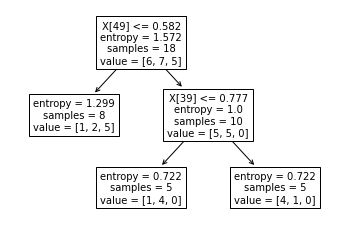

In [29]:
dfForDTree=computeSubSeqDistance(df,CandidateList)
numAttributes=len(dfForDTree.columns.values)
numAttributes-=1
y = dfForDTree['class']
y=y.astype('int')

dfForDTree=dfForDTree.iloc[:,np.r_[:numberOfMotif]] 
print(dfForDTree)
attributes = [col for col in dfForDTree.columns if col != 'TsIndex']
X = dfForDTree[attributes].values


#print(attributes)
#DIVIDO TRAINING SET IN TRAINING E TEST SET



X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.4, #rapporto pattern test/training
                                                    #fissa quali pattern sono scelti per training e test
                                                    stratify=y)



clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, 
                             min_samples_split=4, min_samples_leaf=5) #fissando random state ho sempre lo stesso valore e non ho ranodmicità nello split
clf.fit(X_train, y_train) #genera DTree allenato su tr set

tree.plot_tree(clf,fontsize=10) 

In [30]:
y_predTest = clf.predict(X_test)
print(len(y_predTest))
for y_p, y_tar in zip(y_predTest, y_test):
    print(y_p, y_tar)
    
print(type(y_predTest))
print(type(y_test))

print(classification_report(y_test, y_predTest))
print('Accuracy %s' % accuracy_score(y_test, y_predTest))
print('F1-score %s' % f1_score(y_test, y_predTest, average=None))
confusion_matrix(y_test, y_predTest)

12
1 0
1 0
1 2
2 1
2 1
2 2
1 1
2 0
1 2
1 1
1 0
1 1
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.38      0.60      0.46         5
           2       0.25      0.33      0.29         3

    accuracy                           0.33        12
   macro avg       0.21      0.31      0.25        12
weighted avg       0.22      0.33      0.26        12

Accuracy 0.3333333333333333
F1-score [0.         0.46153846 0.28571429]


C:\Users\Allen\softwaretesi1\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0, 3, 1],
       [0, 3, 2],
       [0, 2, 1]], dtype=int64)